# Определение места бурения новых скважин в добывающей компании «ГлавРосГосНефть»

Компания «ГлавРосГосНефть» занимается нефтедобычей. 

**Цель** - определение локации для бурения новых скважин. 

У компании есть исторические данные о существующих скважинах в различных регионах - качество нефти и объём её запасов. На основе этих данных можно спрогнозировать, где наиболее целесообразно бурить скважину для получения максимального объема нефти и,соответсвенно, максимизации прибыли. На бурение скважины и сотпутсвующие активности будет затрачено немало финансовых ресурсов. Если выбрать локацию неверно, вложения не окупятся.

Для выполнения цели поставлены следующие **задачи**:

- изучить исторические данные характеристик скважин по регионам;
- построить модель для предсказания объёма запасов в новых скважинах;
- используя модель, выбрать скважины с самыми высокими оценками значений;
- определить регион с максимальной суммарной прибылью отобранных скважин и наименьшим риском убытков.

Для исследования предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.Данные геологоразведки трёх регионов находятся в файлах: `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv`. 

В таблицах указаны:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (признаки значимы, научные геологические данные, конкретные обозначения не важны);
- `product` — объём запасов в скважине (тыс. баррелей).

При разведке региона исследуют **500 точек**, из которых с помощью машинного обучения следует **выбрать 200 лучших** для разработки.

Бюджет на разработку скважин в регионе — **10 млрд рублей**. При нынешних ценах один баррель сырья приносит **450 рублей дохода**. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых **вероятность убытков меньше 2.5%**. Среди них выбирают регион с наибольшей средней прибылью.

## 1. Обзор данных

In [1]:
#импортируем библиотеки
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error , r2_score, recall_score, accuracy_score, precision_score, confusion_matrix, 
roc_auc_score, f1_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import stats as st
from sklearn.dummy import DummyRegressor, DummyClassifier
import os
RANDOM_STATE = 42
sns.set_palette("pastel")


In [2]:
metrics=pd.DataFrame()
def reg_metrics(preds, y_valid,dummy_error, region):
    
    """Эта функция рассчитывает метрику RMSE для регрессионной модели, 
     а также показывает среднее предсказание по региону.

    На вход подаются предсказания,  валидационные данные по таргету, название региона. 
    Функция выдает значения в виде таблицы.
    """
    return pd.DataFrame({'регион' : [region],
                         'средний прогнозируемый объем запасов в скважине ':[preds.mean()], 
                         'RMSE':[mean_squared_error(y_valid, preds, squared=False)] ,
                         'dummy-RMSE': [dummy_error]
                         })

In [3]:
if os.path.exists('geo_data_0.csv') and  os.path.exists('geo_data_1.csv') and  os.path.exists('geo_data_2.csv'):
    
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
elif os.path.exists('/datasets/geo_data_0.csv') and os.path.exists('/datasets/geo_data_1.csv') \
and os.path.exists('/datasets/geo_data_2.csv'):
    
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
else:
    print('Something is wrong')

In [4]:
geo_data_0.sample(2)

,id,f0,f1,f2,product
62041,MaWjy,0.724514,0.666063,1.840177,77.696728
35323,QCnAj,-0.054488,1.158118,4.102208,147.003606


In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
geo_data_1.sample(2)

,id,f0,f1,f2,product
52098,094DH,-7.077367,-1.169847,0.999720,30.132364
75384,afsQY,10.418690,-3.631973,2.997482,80.859783


In [8]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
geo_data_2.sample(2)

,id,f0,f1,f2,product
23787,fGxdc,4.343385,3.963224,0.465881,39.411190
93565,i2lXu,-0.789737,0.390866,2.979156,93.322752


In [11]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### 1.1 Вывод
В каждой таблице с характеристиками скважин по региону 100000 записей. Пропусков нет.

## 2. Предобработка данных

Ранее увидели что пропусков нет, оценим наличие дубликатов:

In [13]:
tables = [geo_data_0, geo_data_1, geo_data_2]
for df in tables:
    print(df.duplicated().sum())

0
0
0


In [14]:
for df in tables:
    print(df.id.duplicated().sum())

10
4
4


In [15]:
geo_data_0[geo_data_0.duplicated(subset='id')]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [16]:
geo_data_0[geo_data_0.id=='HZww2']

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


Странно, в датасетах есть дубли уникальных id скважин, при этом характеристики скважин разные. Это может быть ошибка в id или данные по одной скважине, но сделанные в разное время. Так как непонятно как из данных актуальны и неошибочны, уберем из датасетев записи с id у которых есть id-дубликаты.

In [17]:
geo_data_0 = geo_data_0[~geo_data_0.id.isin(geo_data_0[geo_data_0.duplicated(subset='id')]['id'])]
geo_data_1 = geo_data_1[~geo_data_1.id.isin(geo_data_1[geo_data_1.duplicated(subset='id')]['id'])]
geo_data_2 = geo_data_2[~geo_data_2.id.isin(geo_data_2[geo_data_2.duplicated(subset='id')]['id'])]

In [18]:
tables = [geo_data_0, geo_data_1, geo_data_2]
for df in tables:
    print(df.shape)

(99980, 5)
(99992, 5)
(99992, 5)


### 2.1 Вывод
- Пропусков в датасетах нет.
- Дубликатов записей нет.
- Есть дубликаты id для которых представлены разные признаки, записи с этими id удалили.

## 3. EDA

### 3.1 Распределение и разброс признаков
Посмотрим распределение признаков в датасетах. Все признаки - количественные непрерывные.

In [19]:
def hist_for_nums(data, cols, bins = 100):
    for col, ax in zip(cols, axs.ravel()):
        sns.histplot(data = data[col], ax=ax, bins = bins )
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Число скважин')

In [20]:
def box_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.boxplot(data = data[col].values, ax=ax)
        ax.set_title(col)
        ax.set_ylabel(col)

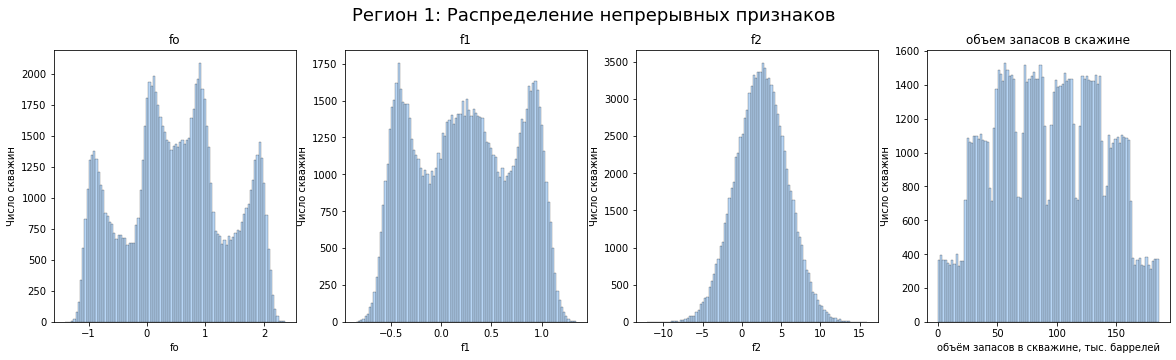

In [21]:
columns = geo_data_0.drop(columns='id').columns
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle('Регион 1: Распределение непрерывных признаков' , fontsize=18,  y=1)
hist_for_nums(geo_data_0,columns)

axs[0].set_title("fo")
axs[0].set_xlabel('fo')

axs[1].set_title("f1")
axs[1].set_xlabel('f1')

axs[2].set_title("f2")
axs[2].set_xlabel('f2')

axs[3].set_title("объем запасов в скажине")
axs[3].set_xlabel('объём запасов в скважине, тыс. баррелей');

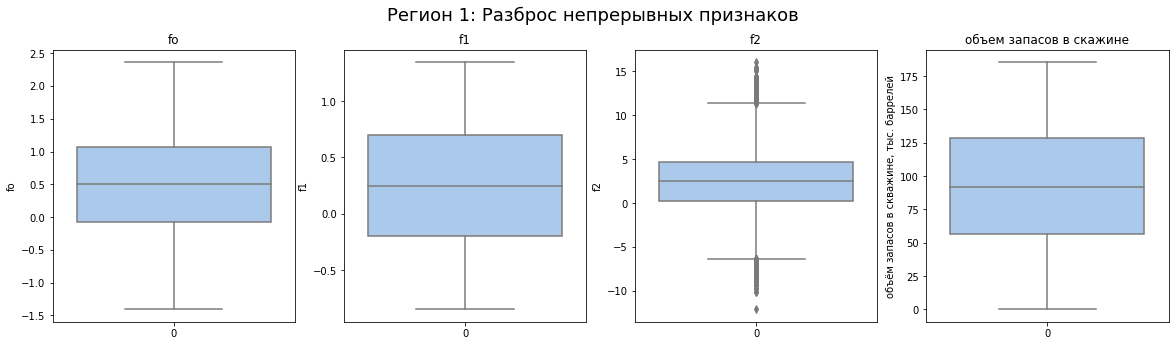

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle('Регион 1: Разброс непрерывных признаков' , fontsize=18,  y=1)
box_for_nums(geo_data_0,columns)

axs[0].set_title("fo")
axs[0].set_ylabel('fo')

axs[1].set_title("f1")
axs[1].set_ylabel('f1')

axs[2].set_title("f2")
axs[2].set_ylabel('f2')

axs[3].set_title("объем запасов в скажине")
axs[3].set_ylabel('объём запасов в скважине, тыс. баррелей');

По  региону 1 близко к нормальному распределению распределены признаки f2 и объем запасов в скважине. Признаки f0 и f1 имеют мультимодальное распределение.

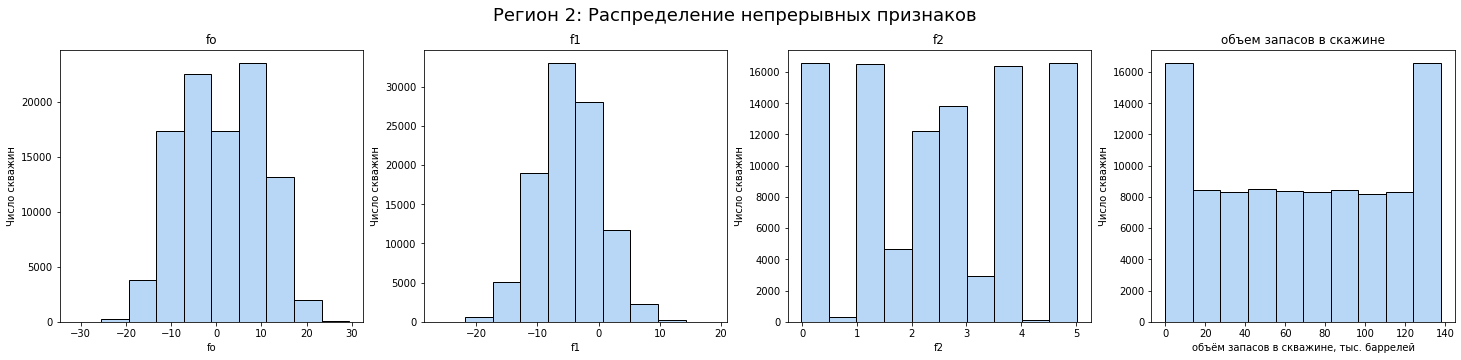

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
fig.suptitle('Регион 2: Распределение непрерывных признаков' , fontsize=18,  y=1)
hist_for_nums(geo_data_1,columns, bins =10)

axs[0].set_title("fo")
axs[0].set_xlabel('fo')

axs[1].set_title("f1")
axs[1].set_xlabel('f1')

axs[2].set_title("f2")
axs[2].set_xlabel('f2')

axs[3].set_title("объем запасов в скажине")
axs[3].set_xlabel('объём запасов в скважине, тыс. баррелей');

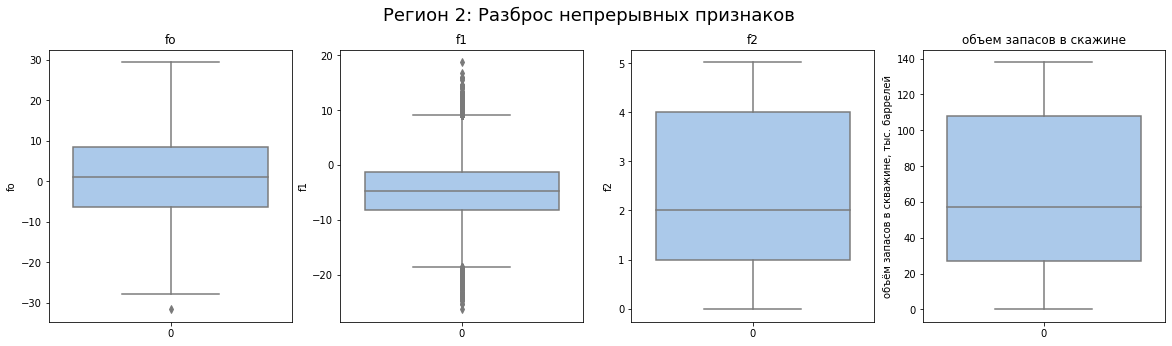

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle('Регион 2: Разброс непрерывных признаков' , fontsize=18,  y=1)
box_for_nums(geo_data_1,columns)

axs[0].set_title("fo")
axs[0].set_ylabel('fo')

axs[1].set_title("f1")
axs[1].set_ylabel('f1')

axs[2].set_title("f2")
axs[2].set_ylabel('f2')

axs[3].set_title("объем запасов в скажине")
axs[3].set_ylabel('объём запасов в скважине, тыс. баррелей');

По региону 2 близко к нормальному распределению распределен только признак f1.

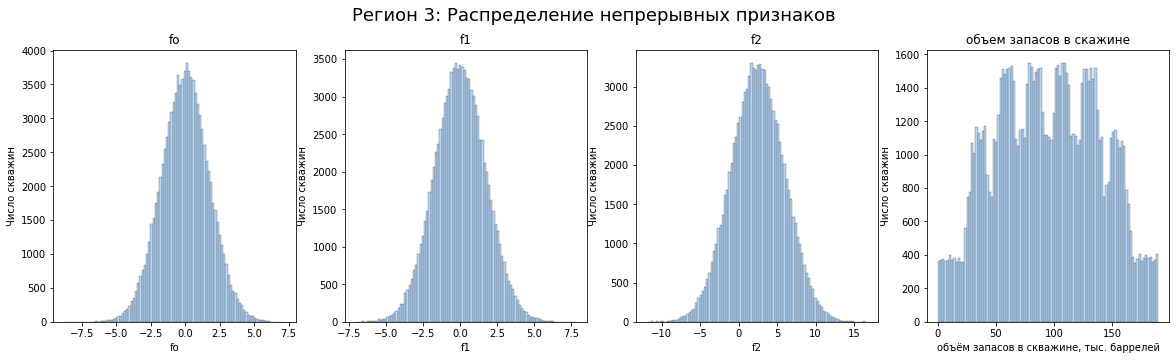

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle('Регион 3: Распределение непрерывных признаков' , fontsize=18,  y=1)
hist_for_nums(geo_data_2,columns)

axs[0].set_title("fo")
axs[0].set_xlabel('fo')

axs[1].set_title("f1")
axs[1].set_xlabel('f1')

axs[2].set_title("f2")
axs[2].set_xlabel('f2')

axs[3].set_title("объем запасов в скажине")
axs[3].set_xlabel('объём запасов в скважине, тыс. баррелей');

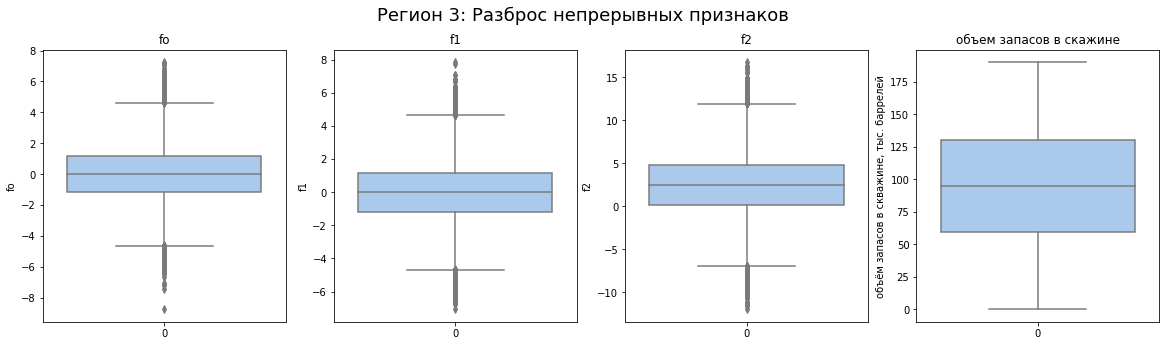

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle('Регион 3: Разброс непрерывных признаков' , fontsize=18,  y=1)
box_for_nums(geo_data_2,columns)

axs[0].set_title("fo")
axs[0].set_ylabel('fo')

axs[1].set_title("f1")
axs[1].set_ylabel('f1')

axs[2].set_title("f2")
axs[2].set_ylabel('f2')

axs[3].set_title("объем запасов в скажине")
axs[3].set_ylabel('объём запасов в скважине, тыс. баррелей');

По региону 3 все признаки распределны близко к нормальному распределению.

### 3.2 Корреляции между признаками

Так как для регионов 1 и 2 не все характеристики нормально распределены посчитаем коэффициенты корреляции Спирмена. Для третьего региона - посчитаем корреляции Пирсона.

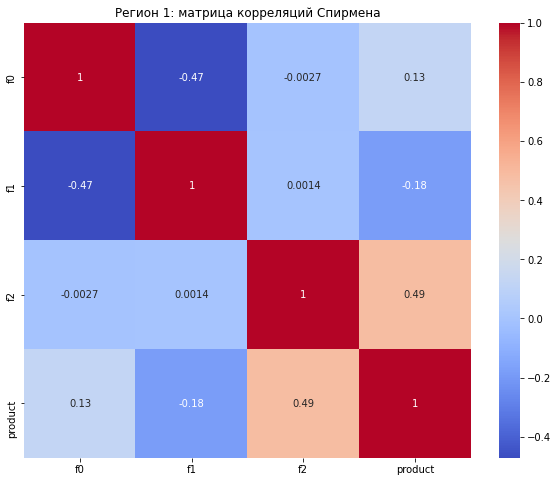

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(geo_data_0[columns].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Регион 1: матрица корреляций Спирмена')
plt.show();

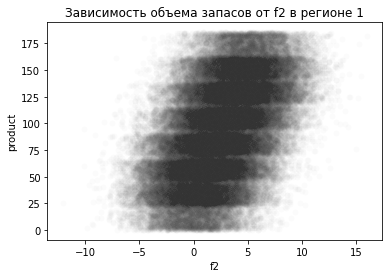

In [28]:
plt.title('Зависимость объема запасов от f2 в регионе 1')
sns.scatterplot(data=geo_data_0, x='f2', y ='product',color=".2", alpha = 0.02);

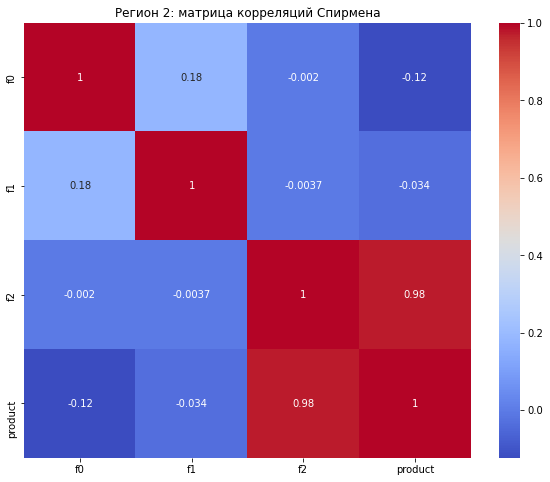

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(geo_data_1[columns].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Регион 2: матрица корреляций Спирмена')
plt.show();

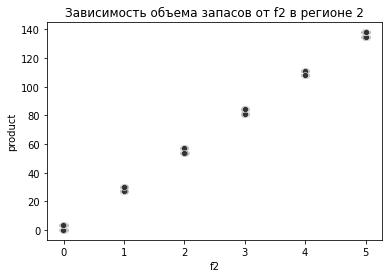

In [30]:
plt.title('Зависимость объема запасов от f2 в регионе 2')
sns.scatterplot(data=geo_data_1, x='f2',color=".2", y ='product');

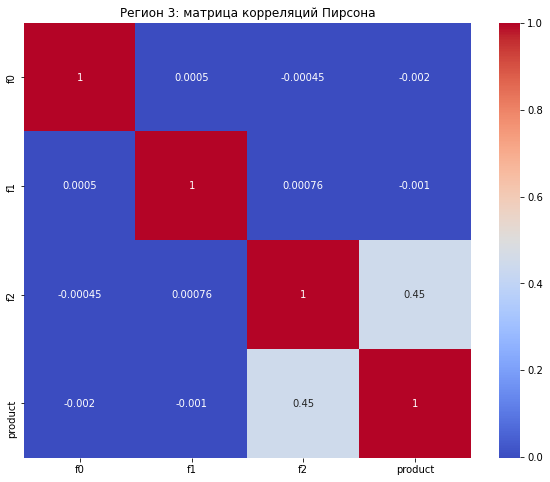

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(geo_data_2[columns].corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Регион 3: матрица корреляций Пирсона')
plt.show();

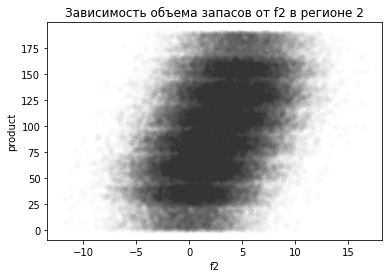

In [32]:
plt.title('Зависимость объема запасов от f2 в регионе 2')
sns.scatterplot(data=geo_data_2, x='f2', y ='product', color=".2", alpha=0.02);

- Для региона 1 f0 и f1 умеренно отрицательно коррелируют. f2 умеренно положительно коррелирует с таргетом product ( объемом запасов в скважине).
- Для региона 2 f2 практически полностью определяет таргет. Остальные признаки незначительно связаны между собой.
- Для региона 3 f2 умеренно положительно коррелирует с таргетом. Остальные признаки незначительно связаны между собой.

### 3.3 Вывод по EDA

- В зависимости от региона признаки наблюдаем разные формы распределение признаков. Все признаки только в регионе 3 распределены нормально. 
- Значительная корреляция признака f1 с таргетом - общая закономерность для всех регионов. Однако в случае региона 2 f2 практически полностью определяет таргет - значение коэффициента корреляции 0.98.

## 4. Построение моделей

Подготовим данные и посторим модель линейной регрессии. Таргет - product (объем запасов в скажине, тыс.баррелей). f0, f1, f2 - входные признаки. Оценивать точность моделей будем с помощью метрики RMSE.

### 4.1 Подготовка данных

Входные признаки стандартизуем с помощью StandardScaler(). 

In [33]:
cols = ['f0', 'f1', 'f2']

In [34]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), cols)
    ], 
    remainder='passthrough'
)

In [35]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

### 4.2 Модели 

In [36]:
def modeling(data):
    X = data.drop(['product', 'id'], axis=1)
    y = data['product']
    X_train,X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,  random_state=RANDOM_STATE)
    pipe_final.fit(X_train, y_train)
    preds = pipe_final.predict(X_valid)
    y_preds = pd.Series(preds)
    y_valid = y_valid.reset_index(drop=True)
    
    pipe_dummy = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyRegressor(strategy="mean"))
    ]
    )
    pipe_dummy.fit(X_train, y_train)
    dummy_preds = pipe_dummy.predict(X_valid)
    dummy_error = mean_squared_error(y_valid, dummy_preds, squared=False)

    return y_preds, y_valid, dummy_error

In [37]:
y_preds_reg_1,y_valid_reg_1,dummy_error_1  = modeling(geo_data_0)
y_preds_reg_2,y_valid_reg_2, dummy_error_2 = modeling(geo_data_1)
y_preds_reg_3,y_valid_reg_3,dummy_error_3  = modeling(geo_data_2)

In [38]:
metrics=metrics.append([reg_metrics(y_preds_reg_1, y_valid_reg_1,dummy_error_1,  1), reg_metrics(y_preds_reg_2, y_valid_reg_2,dummy_error_2,  2), 
                        reg_metrics(y_preds_reg_3, y_valid_reg_3,dummy_error_3, 3)])

metrics

,регион,средний прогнозируемый объем запасов в скважине,RMSE,dummy-RMSE
0,1,92.286539,37.761147,44.258708
0,2,69.168941,0.892864,45.971453
0,3,94.820691,40.131156,44.725449


Ошибка дамми регрессора выше, значит наши модели решает задачу лучше, чем константная модель.

### 4.5 Вывод
- Регион 2 в среднем имеет наименьший прогнозируемый объем запасов в скажине и в то же время предсказания очень точные, ошибка низкая (видимо, по причине сильно корреляции f2 c таргетом).
- В Регионе 3 согласно предсказанию наибольший средний объем запасов в скважине, но при этом и самый большой разброс значений, что показывает величина RMSE.


## 5. Расчет прибыли 
### 5.1 Подготовка к расчету 

Все ключевые значения для расчётов сохраним в отдельных переменных.

In [39]:
# При разведке региона исследуют 500 точек
N = 500
# из которых с помощью машинного обучения выбирают 200 лучших
COUNT = 200
# Бюджет на разработку скважин в регионе
BUDGET = 10_000_000_000
# Доход с каждой единицы (тыс баррелей) продукта
PRICE_UNIT = 450000

Для того, чтобы разработка была безубыточна, нужно чтоб стоимость объема запасов ново разработанных скважин превышала бюджет разработки.

In [40]:
# достаточный объём сырья для безубыточной разработки новой скважины равен

print(f'Достаточный объём сырья для безубыточной разработки новой скважины равен {round(BUDGET/(COUNT*PRICE_UNIT), 2)} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины равен 111.11 тыс. баррелей


In [41]:
print(f"Cредний запас в скважине в регионе 1 равен {round(geo_data_0['product'].mean(),2)}")
print(f"Cредний запас в скважине в регионе 2 равен {round(geo_data_1['product'].mean(),2)}")
print(f"Cредний запас в скважине в регионе 3 равен {round(geo_data_2['product'].mean(),2)}")

Cредний запас в скважине в регионе 1 равен 92.5
Cредний запас в скважине в регионе 2 равен 68.82
Cредний запас в скважине в регионе 3 равен 95.0


In [42]:
print(f"Cредний запас в скважине из 200 лучших вариантов в регионе 1 равен {round(geo_data_0['product'].sort_values(ascending=False).head(200).mean(),2)}")
print(f"Cредний запас в скважине из 200 лучших вариантов в регионе 2 равен {round(geo_data_1['product'].sort_values(ascending=False).head(200).mean(),2)}")
print(f"Cредний запас в скважине из 200 лучших вариантов в регионе 3 равен {round(geo_data_2['product'].sort_values(ascending=False).head(200).mean(),2)}")

Cредний запас в скважине из 200 лучших вариантов в регионе 1 равен 184.83
Cредний запас в скважине из 200 лучших вариантов в регионе 2 равен 137.95
Cредний запас в скважине из 200 лучших вариантов в регионе 3 равен 189.55


**Вывод**

Cредний запас сырья в скважине (учитывая все данные в исходных таблицах) в регионах ниже, чем требуется в новой скважине для безубыточной разработки. Значит нельзя для разработки взять любые 200 скважин, необходимо выбрать скважины 200 скважин с максимальным объемом запасов. 

### 5.2 Расчет прибыли и рисков

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. 

В функции:
- Выберем скважины с максимальными значениями предсказаний. 
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

In [43]:
def profit(y_preds, y_valid, count, price_per_unit, budget):
    y_preds_sorted = y_preds.sort_values(ascending=False)
    return (price_per_unit * y_valid[y_preds_sorted.index][:count].sum()) - budget

In [44]:
profit(y_preds_reg_3,y_valid_reg_3, COUNT,PRICE_UNIT, BUDGET)

2103914701.2991962

Функция вроде бы работает верно.

Теперь, 
- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [45]:
def bootstrap_region(y_valid, y_preds):
    values = []
    state = np.random.RandomState(12345)
    for i in range(1000):
        sampl = y_valid.sample(n=N, replace=True, random_state=state) 
    
        values.append(profit(y_preds[sampl.index],sampl, COUNT, PRICE_UNIT, BUDGET)/1_000_000)

    values = pd.Series(values)
# 95%  доверительный интервал
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
# средняя прибыль
    mean = values.mean()
# риск убытка
    p_risk = values[values<0].count()/values.count()*100
    
    print("Средняя прибыль,  млн руб:", round(mean,2))
    print(f"95%-ный доверительный интервал для прибыли: от {round(lower,2)} млн руб до {round(upper,2)} млн руб")
    print("Риск убытка:", round(p_risk,2), "%")

In [46]:
print('Регион 1')
bootstrap_region(y_valid_reg_1, y_preds_reg_1)

Регион 1
Средняя прибыль,  млн руб: 424.64
95%-ный доверительный интервал для прибыли: от -129.56 млн руб до 999.55 млн руб
Риск убытка: 6.6 %


In [47]:
print('Регион 2')
bootstrap_region(y_valid_reg_2, y_preds_reg_2)

Регион 2
Средняя прибыль,  млн руб: 547.01
95%-ный доверительный интервал для прибыли: от 112.94 млн руб до 966.48 млн руб
Риск убытка: 0.6 %


In [48]:
print('Регион 3')
bootstrap_region(y_valid_reg_3, y_preds_reg_3)

Регион 3
Средняя прибыль,  млн руб: 383.22
95%-ный доверительный интервал для прибыли: от -129.5 млн руб до 959.79 млн руб
Риск убытка: 7.2 %


### 5.3 Вывод

**Второй регион** является наиболее привлекательным, если рассматривать среднюю прибыль и вероятность понести убытки, т.к. для этого региона самая высокая прибыль от разработки скважин и наименьшие риски убытков (подходит под критерий менее 2.5% риска убытков) относительно остальных двух регионов.

## 6. Итоговый вывод исследования

1. **Обзор данных**
Данные геологоразведки трёх регионов находятся в таблицах: `geo_data_0`,`geo_data_1`, `geo_data_2`.В каждой таблице с характеристиками скважин по региону 100000 записей. В таблицах представлены значимы признаки f0, f1, f2, а также целевой признак product - объем запасов в скважине (тыс.баррелей).

2. **Предобработка данных**
- Пропусков в датасетах нет.
- Дубликатов записей нет.
- Есть дубликаты id для которых представлены разные признаки, записи с этими id удалили.

3. **EDA**
- В зависимости от региона признаки наблюдаем разные формы распределение признаков. Все признаки только в регионе 3 распределены нормально. 
- Значительная корреляция признака f1 с таргетом - общая закономерность для всех регионов. Однако в случае региона 2 f2 практически полностью определяет таргет - значение коэффициента корреляции 0.98.

4. **Построение моделей**
- Для каждого региона построена модель линейной регрессии. Входные признаки - признаки f0, f1, f2 для этого региона, таргет - признак product.
- Полученные модели адекватны.
- Регион 2 в среднем имеет наименьший прогнозируемый объем запасов в скажине и, в то же время, очень точные предсказания, ошибка низкая (видимо, по причине сильно корреляции f2 c таргетом).
- В Регионе 3 согласно предсказанию наибольший средний объем запасов в скважине, но при этом и самый большой разброс значений, что показывает величина RMSE.

5. **Расчет прибыли и определение наиболее прибыльного региона**
- Достаточный объём сырья в одной скважине из 200 для безубыточной разработки новой скважины равен 111.11 тыс. баррелей. Это выше, чем среднее значение по каждому региону по всей выборке. Значит нельзя для разработки взять любые 200 скважин, необходимо выбрать скважины 200 скважин с максимальным объемом запасов. 
- При помощи техники Bootstrap с 1000 выборок нашли распределение прибыли и посчитали среднее значение прибыли, 95% доверительный интервал и риск убытков в каждом регионе на условиях бизнеса: 
  - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения следует выбрать 200 лучших для разработки. 
  - Бюджет на разработку скважин в регионе — 10 млрд рублей. 
  - Доход с каждой единицы продукта составляет 450 тыс. рублей. 
  - Оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.
- Для **первого региона** средняя прибыль составит 424.64 млн рублей. 95%-ный доверительный интервал для прибыли: от -129.56 млн руб до 999.55 млн руб. При этом риск убытка составит 6.6 %
- Для **второго региона** средняя прибыль составит 547.01 млн рублей. 95%-ный доверительный интервал для прибыли: от 112.94 млн руб до 966.48 млн руб. При этом риск убытка минимальный - 0.6%.
- Для **третьего региона** средняя прибыль составит 383.22 млн рублей. 95%-ный доверительный интервал для прибыли: от -129.5 млн руб до 959.79 млн руб. При этом риск убытка наибольший из трех - 7.2%.

**Таким образом, для разработки следует выбрать второй регион**, т.к. для этого региона самая высокая прибыль от разработки 200 скважин и наименьшие риски убытков (подходит под критерий менее 2.5% риска убытков) относительно остальных двух регионов.